In [46]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import numpy as np
from PIL import Image, ImageOps
import voxelmorph as vxm
import neurite as ne
import tensorflow as tf
import cv2
import time
from sklearn.metrics.cluster import normalized_mutual_info_score
import statistics

## FOR USER: choose directories and registration method

In [127]:
inital_directory = '/data/ml4s2021/venvs/'
output_directory = '/data/ml4s2021/venvs/output'
img_src_patch = '../data/2021_11_12/OphtalmoLaus/'

"""Please choose the number of patients whose images you want to align:"""
max_patients = 2

"""Please define the alignement method, choices are: 'SIFT', 'AKAZE', 'ORB' and 'VOXELMORPH'"""
ALIGN_METHOD = 'AKAZE'

"""If you chose VOXELMORPH, please specify which centeredness you would like (LOHN, LMacula, ROHN, RMacula),
otherwise leave it empty '':"""
VXM_METHOD = ''

## Helper functions

#### Filtering functions

In [122]:
# GRAYSCALE FILTERING USING NAKA-RUSHTON ALGORITHM:

def filter_image(img):
    """Input: image as 2D numpy.ndarray
    Output: returns filtered ndarray image using Naka-Rushton filtering algorithm.
    This produces a gray-level compression/equalization of the image (i.e. the range is constricted).
    This produces higher contrast between blood vessels and background."""
    pxls = np.zeros((img.shape[0],img.shape[1]))
    window = 44
    half_win = int(window/2)

    for i in range(img.shape[0]):
        for k in range(img.shape[1]):
            if i < window or i > img.shape[0]-window or k < window or k > img.shape[1]-window:
                img[i,k] = 0.0

    for i in range(img.shape[0]):
        for k in range(img.shape[1]):
            if (i > half_win and i < img.shape[0]-half_win) and (k > half_win and k < img.shape[1]-half_win):
                average = img[i-half_win:i+half_win, k-half_win:k+half_win].mean()
                if img[i,k] != 0.0 and average != 0.0:
                    img[i,k] = img[i,k]*(img[i,k]/(img[i,k]+average))
    return img

# THRESHOLDING FUNCTION:

def threshold(img_thresh):
    """Input: image as numpy.ndarray
    Output: returns filtered ndarray image where all pixels below threshold are white and above are black.
    However, since we want to see the vessels in white and all else in black, we also made the background
    around the image white since the vessels are darker than other parts of the retina after Naka-Rushton.
    We use for this an adaptive threshold with a block size of 91."""
    thresh = 135 #Threshold value found empirically for first patient

    for i in range(img_thresh.shape[0]):
        for k in range(img_thresh.shape[1]):
            if img_thresh[i,k] < 30.0:
                img_thresh[i,k] = 255.0
    
    img_threshold = np.copy(img_thresh)
    #T, img_threshold = cv2.threshold(img_thresh, thresh, 255, cv2.THRESH_BINARY_INV)
    img_threshold = cv2.adaptiveThreshold(img_thresh,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,91,5)
    return img_threshold

# DENOISING FUNCTIONS:

def apply_threshold_with_denoising(image):
    """Input: B&W image as numpy.ndarray
    Output: returns denoised ndarray image using Non-local Means Denoising algorithm with several
    compurational optimizations."""
    denoised = cv2.adaptiveThreshold(image, 250, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 1)
    denoised = cv2.fastNlMeansDenoising(denoised, 1.5, 5, 5)
    return denoised

def delete_small_components(image, filtered_img, size):
    """Input: B&W image as numpy.ndarray
    Output: returns ndarray image with small noise components removed using a kernel of dimensions '(size)'."""
    nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(filtered_img,None,None,None,8,cv2.CV_32S)
    sizes = stats[1:, -1]
    image = np.zeros(labels.shape, np.uint8)
    
    for i in range(0, nlabels-1):
        if sizes[i] >= 150:
            image[labels == i+1] = 255
    return image

def kernel(size1, size2):
    """Function to create kernel of ones of dimension (size1, size2)"""
    return np.ones((size1,size2), np.uint8)

def denoise_image(filtered_img):
    """Function that denoises given ndarray image using above functions"""
    denoised = apply_threshold_with_denoising(filtered_img)
    kernel22 = cv2.dilate(denoised, kernel(2,2), iterations=2)
    denoised = delete_small_components(kernel22, filtered_img, 5)
    return denoised

#### General helper functions

The function __improve_contrast__ takes into argument an image and returns an image with improved contrast.
To improve the contrast of the image, two steps are required. 
In the first step the image get converted into the LAB colour model.
This means it is described by three matrices: the matrice __a__ , describing the intensity and color (range from green to red), the matrice __b__ , describing the intensity and color (range from blue to yellow) and the matrice __l__ containing information about the brightness of every pixel.

In the second step we apply a contrast limited adaptive histogram equalization (__CLAHE__ ) (more information in the report) to the __l__ matrix, and merge the transformed __l__ matrix back with the __a__ and __b__ matrices.


In [49]:
def resize(img, scale):
    """ Takes into argument an image and a scaling factor.
    Returns an image that was scaled by the scaling factor"""
    width = int(img.shape[1] * scale)
    height = int(img.shape[0] * scale) 
    dim = (width, height)
    
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized

def rotate(image, degree):
    """ Takes into argument an image and an int degree.
    Returnd the image rotated by 'degree' degrees. """
    (heigth, width) = image.shape[:2]
    (centreX, centreY) = (width // 2, height // 2)
    
    M = cv2.getRotationMatrix2D((centreX, centreY), degree, 1.0)
    return cv2.warpAffine(image, M, (width, heigth))

def shift(image, x, y):
    """ Takes into argument an image and two ints.
    x and y define how far one wants to shift the image on the corresponding axis.
    x and y can also be negative."""
    num_rows, num_cols = image.shape[:2]
    
    translation_matrix = np.float32([ [1,0,x], [0,1,y] ])
    img_translation = cv2.warpAffine(image, translation_matrix, (num_cols, num_rows))
    
    return img_translation

def improve_contrast(img):
    """Takes into argument an image and returns an image with improved contrast.
    For more information see describtion above or report."""
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l,a,b = cv2.split(lab)
    
    clahe = cv2.createCLAHE(clipLimit = 3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    
    limg = cv2.merge((cl,a,b))
    enhanced = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    
    return enhanced

def blend(img1, img2):
    """Function that takes two images and returns the blended/superposed version
    using alpha = 0.5"""
    blended_image = cv2.addWeighted(img1, 0.5, img2, 0.5, 0.0)
    return blended_image

def vxm_data_generator(x_data, batch_size=32):
    """Function used for generating vxm data.
    Generator that takes in data of size [N, H, W] and yields data for custom vxm model.
    Note that we need to provide numpy data for each input and output.
    
    inputs: moving [bs, H, W, 1], fixed_image[bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2
    ]"""
    vol_shape = x_data.shape[1:]
    ndims = len(vol_shape)
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

#### Functions to help load the entire dataset

The function __split(string)__ takes a string as an argument, and returns the first element of the string separated by a __'-'__ as an integer. In this case the function returns the __patient number__ of an image name in form of an integer.

The function __Extract(list)__ will return the patient numbers of the images in the list given as argument.
To do so, every element of the list is called in the function __split(string)__, which generates a new list __isolated_numbers__ where every element is a list (containing the patient number as an int, and the rest of the name as a string).
Then the function only returns the first sub-element of every element in __isolated_numbers__, meaning that we return only the patients numbers.

The function __generate_indexes_of_patients(list)__ returns unique patient numbers in an ordered way. 
It takes as an argument a list of names from patients images. It calls __Extract(list)__ to obtain the patient number of every image. Then it removes the doubles using __set()__ and orders the numbers using __sorted()__.

The function __getImages(list, side, centering)__ returns of a list of images only the one with given centering (OHN or macula) and side (left (L) or right (R)).
To do so, every name is split at the character __'-'__ and the splitted strings are stored in the list called __image_data__. We know, that the side is the third element and the centering is the fifth element.
In the __for-loop__ we iterate over the list of images __image_data__ and test whether the centering and side are corresponding to the requirements. If yes, the given image is added to the __return_list__ which is, as the name indicates, returned after the completion of the for-loop.

The function __output__ takes as argument an image and a string that defines the images name.
The image is outputted in the folder defined by the output_directory path.

The function __treat_patients_images(list)__ takes as an argument a list of images of a patient. 
As we do not want to align all images of a given patient together, we need to iterate over every combination of centering and side. And for every of those combination, __getImages()__ is called to generate a list only containing the images of said combination and store it in __images___.
It can happen, that there is no image for a given side and centering. Therefore, we proceed only if the list __images___ is non-empty.
Then, the function __call_align_function()__ is called to align the images.

The function __call_align_function(imgs)__ takes as argument a list of images of the same orientation and side. The first image is taken as a reference and saved in the output folder by calling it with the function __output__.
If we have more than one image in the list __imgs__, we can align them to the first one.
In the for loop the all images (except the first) and align them to the reference image (first image).
Depending on the __ALIGN_METHOD__ choosen by the user, voxelmorph, orb, sift or akaze is used to align the images.
If __ALIGN_METHOD__ is not properly defined, sift is used as default method.

The function __filter___ takes as argument a list of image names.
The corresponding images are read and filtered.
The function returns two vectors: one with the filtered images and one with the unfiltered images.


In [112]:
# Functions used in the process of iterating over the patients
def split(s):
    """ takes as argument the name of an image and returns the patients number."""
    a= s.split("-", 1)
    a[0] = int(a[0])
    return a

def Extract(lst):
    """Takes as argument a list of image names and returns all the patient numbers in a list of integers."""
    isolated_numbers = list(map(split, lst))
    return [int(item[0]) for item in isolated_numbers]

def generate_indexes_of_patients(my_list):
    """Takes as argument a list of patient numbers and removes the duplicates and sort them.
    It returns a list of all the single patient numbers an ordered way."""
    final = set(Extract(my_list))
    return sorted(final)

# Functions to align the images of a given patient
def treat_patients_images(imgs):
    centre = ['OHN', 'macula']
    side = ['L', 'R']
    
    for c in centre:
        for s in side:
            images_ = getImages(imgs, s, c)
            if images_:
                if VXM_METHOD == '':
                    call_align_function(images_)
                elif VXM_METHOD == 'LOHN':
                    if c=='OHN' and s=='L':
                        call_align_function(images_)
                elif VXM_METHOD == 'ROHN':
                    if c=='OHN' and s=='R':
                        call_align_function(images_)
                elif VXM_METHOD == 'LMacula':
                    if c=='macula' and s=='L':
                        call_align_function(images_)
                elif VXM_METHOD == 'RMacula':
                    if c=='macula' and s=='R':
                        call_align_function(images_)

def getImages(images, side, centre):
    """takes as argument a list of image names, and two strings defining side and center.
    It returns a list containing all images of given side and centering of the initial list of images."""
    return_list = []
    image_data = [(i).split('-') for i in images]
    for im in image_data:
        if ((im[2] == side) and (im[4] == centre)):
            return_list.append('-'.join(im))
    return return_list

def output(img, img_name):
    """Takes as argument an image and a string that defines the images name.
    The image is outputted in the folder defined by the output_directory path."""
    print('Writing :',img_name)
    os.chdir(output_directory)
    cv2.imwrite(img_name, img)
    os.chdir(inital_directory)

def call_align_function(imgs):
    """Takes as argument a list of images of the same orinetation and side and aligns them.
    Depending on the ALIGN_METHOD defined by the user, the alignment method can either be orb, sift, akaze 
    or voxelmorph (more details in the report)"""
    
    print('New iteration')
    first_original = improve_contrast(cv2.imread(img_src_patch+imgs[0]))
    output(first_original, imgs[0])
    
    if len(imgs) > 1:
        filtered, originals = filter_(imgs)
        for i in range(len(imgs) - 1):
            
            if ALIGN_METHOD == 'ORB':  
                aligned_image = align_orb(filtered[0], filtered[i+1], originals[i+1])
                output(aligned_image, imgs[i + 1])
                error_MI.append(mutual_info(originals[0], aligned_image))
            elif ALIGN_METHOD == 'SIFT':  
                aligned_image = align_sift(filtered[0], filtered[i+1], originals[i+1])
                output(aligned_image, imgs[i + 1])
                error_MI.append(mutual_info(originals[0], aligned_image))
            elif ALIGN_METHOD == 'AKAZE':  
                aligned_image = align_akaze(filtered[0], filtered[i+1], originals[i+1])
                output(aligned_image, imgs[i + 1])
                error_MI.append(mutual_info(originals[0], aligned_image))
            elif ALIGN_METHOD == 'VOXELMORPH':
                val_input, _ = next(val_generator)
                aligned_image = align_voxelmorph(val_input, vxm_model)
                output(aligned_image, imgs[i + 1])
                error_MI.append(mutual_info(val_input[0][0,:,:,0], aligned_image))
            else: 
                print('The ALIGN_METHOD is not properly defined. As a default the aligning was done using SIFT')
                aligned_image = align_sift(filtered[0], filtered[i+1], originals[i+1])
                output(aligned_image, imgs[i + 1])
                error_MI.append(mutual_info(originals[0], aligned_image))

def filter_(image_list):
    """takes as argument a list of image names.
    The corresponding images are read and filtered.
    The function returns two vectors: one with the filtered images and one with the unfiltered images. """
    filtered = []
    originals = []
    for img in image_list:
        image_original = cv2.imread(img_src_patch+img)
        image_original = improve_contrast(image_original)
        if ALIGN_METHOD == 'VOXELMORPH':
            image_original = cv2.cvtColor(image_original, cv2.COLOR_BGR2GRAY)
            image_in_process = np.copy(image_original)
        else:
            image_in_process = cv2.cvtColor(image_original, cv2.COLOR_BGR2GRAY)
        image_in_process = denoise_image(threshold(image_in_process))
        filtered.append(image_in_process)
        originals.append(image_original)
    
    return filtered, originals

### Distance between two images (i.e. Registration Distance)
To measure similarity / distance of two images we decided to use the mutual information (MI). It describes the mutual dependence of the two images by quantifying the amount of information that can be obtained about one image by looking at the other image.
The value describes the difference between the sum of the entropy of the two images and the joint entropy of the images.
There is a predefined function that computes MI in  the __sklear.metrics__ library. The function __normalized_mutual_info_score__ returns the normalized value of the MI, 1 if the images are identical, and zero if they are completely independent.
As we should provide a function that returns 0 for identical and 1 for distinct images, we need to return 1 - MI.

In [51]:
def mutual_info(img1, img2):
    """takes as argument two images and returns their normalized mutual information.
    For more information see cell above or report."""
    return (1-normalized_mutual_info_score(img1.ravel(), img2.ravel()))

### Voxelmorph functions
The function __groups_for_voxelmorph__ Takes as argument a list of image names and an int max_nbr.
It returns four lists of images (not names) for every combination (of centering and side).
max_nbr defines the maximal length of the returned lists.
The sorted images will then be used to train the __voxelmorph-model__.

The function __getImagesVoxel__ takes as argument a list of image names, two strings for side and centering and an integer max_nbr.
It returns a list with the first max_nbr images (not the names) of the given side and orientation.

In [54]:
def groups_for_voxelmorph(imgs, max_nbr = 50):
    """Takes as argument a list of image names and an int max_nbr.
    It returns four lists of images (not names) for for every combination (of centering and side).
    max_nbr defines the maximal length of the returned lists."""
    imagesLOHN = getImagesVoxel(imgs, 'L', 'OHN', max_nbr)
    imagesLMacula = getImagesVoxel(imgs, 'L', 'macula', max_nbr)
    imagesROHN = getImagesVoxel(imgs, 'R', 'OHN', max_nbr)
    imagesRMacula = getImagesVoxel(imgs, 'R', 'macula', max_nbr)
    
    return imagesLOHN, imagesLMacula, imagesROHN, imagesRMacula

def getImagesVoxel(imgs, side, centering, max_nbr):
    """Takes as argument a list of image names, two strings for side and centering and an integer max_nbr.
    It returns a list with the first max_nbr images (not the names) of the given side and orientation."""
    imgs = getImages(imgs, side, centering)
    if max_nbr < len(imgs):
        imgs = imgs[0:max_nbr]
    else:
        print('error: you try to use more elements of imgs than there are.')
    return_list = []

    for im in imgs:
        color = cv2.imread(img_src_patch+im)
        gray = cv2.cvtColor(color, cv2.COLOR_BGR2GRAY)
        gray = gray[7:1927,328:2248]
        if len(return_list) > 1:
            if (return_list[0].shape == gray.shape):
                return_list.append(gray)
            else:
                print('skipped following image because its size was not conform: ', im)   
        else:
            return_list.append(gray)
    
    return return_list

# Main

### Registering images by iterating over the patients

__images__ is the list containing the names of all images of the source folder.

__error_MI__ is a list to store the mutual information of every alignment.

There is one element in the image-source folder called __'Thumbs.ds'__, we remove that in order to be able to iterate over the other images.

__nbrs_of_all_images__ is a vector conatining only the patient numbers of every image in the dataset in the original orders.

But most patients have several images and not every number is given to a patients. To make it easier to iterate over all existing patient numbers, we introduce __patient_indices__ which contains every patients number only once, starting with the smallest number and then increasing.


The __for-loop__ iterates over the different patients.

__ind__ are the indices of images belonging to the patient of interest, and __images_of_interest__ is a vector containing the full name of the images belonging to said patient.
The function __treat_patient_images__ giving __images_of_interest__ as an argument, will align the images in the way we wish.

In [ ]:
images = os.listdir(img_src_patch)
error_MI = []

images.remove('Thumbs.db')

nbrs_of_all_images = np.asarray(Extract(images))
patient_indices = generate_indexes_of_patients(images)

"""If we are using the VoxelMorph registration model:"""
if ALIGN_METHOD == 'VOXELMORPH':
    edge_length = int(1920*0.3)
    imagesLOHN, imagesLMacula, imagesROHN, imagesRMacula = groups_for_voxelmorph(images)
    if VXM_METHOD == 'LOHN':
        vxm_model = train_voxelmorph(imagesLOHN)
        images_train = np.zeros((len(imagesLOHN), edge_length, edge_length))
        for i in range(len(imagesLOHN)):
            images_train[i] = resize(imagesLOHN[i], 0.3)
    elif VXM_METHOD == 'LMacula':
        vxm_model = train_voxelmorph(imagesLMacula)
        images_train = np.zeros((len(imagesLMacula), edge_length, edge_length))
        for i in range(len(imagesLMacula)):
            images_train[i] = resize(imagesLMacula[i], 0.3)
    elif VXM_METHOD == 'ROHN':
        vxm_model = train_voxelmorph(imagesROHN)
        images_train = np.zeros((len(imagesROHN), edge_length, edge_length))
        for i in range(len(imagesROHN)):
            images_train[i] = resize(imagesROHN[i], 0.3)
    elif VXM_METHOD == 'RMacula':
        vxm_model = train_voxelmorph(imagesRMacula)
        images_train = np.zeros((len(imagesRMacula), edge_length, edge_length))
        for i in range(len(imagesRMacula)):
            images_train[i] = resize(imagesRMacula[i], 0.3)

    val_generator = vxm_data_generator(images_train, batch_size=1)


reduced_patient_indices = patient_indices[0:max_patients]

for patient_nbr in reduced_patient_indices:
    ind = np.where(nbrs_of_all_images == patient_nbr)[0]
    images_of_interest = [images[i] for i in ind]
    treat_patients_images(images_of_interest)

print('\nAverage mutual information score using', ALIGN_METHOD,':',statistics.mean(error_MI),\
      'with standard deviation:', statistics.stdev(error_MI))

### Using small test sample

This can be used to test the functionality of each of our functions/methods using a small subset of the dataset (about 4 images).

In [84]:
img_src_patch = '../data/2021_11_12/OphtalmoLaus/'

images = os.listdir(img_src_patch)
images_original, images_jpg = [],[]
img_count = 0

#Initially loading small training set. For this project, the constraint is to separate right from left eyes,
#macula- vs OHN-centered images as well as images from different patients.
for i in images:
    if i.startswith('1-20211006-R-cfi-macula'):
        #Improving contrast then transforming images into grayscale
        #We are also transforming the images into square 1920x1920 images for VoxelMorph and visuals
        img_color = cv2.imread(img_src_patch+i)
        img_color = improve_contrast(img_color)
        images_original.append(img_color[7:1927,328:2248])
        img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
        images_jpg.append(img_gray[7:1927,328:2248])
        img_count += 1

#### Creating training set for VoxelMorph method

In [58]:
edge_length = 120*(2**4) #Edge length needs to be a multiple of 2^N with N the number of CNN layers
edge_length = int(edge_length*0.3) #We take a size equal to 30% of the original image to be able to train vxm
dim1,dim2,dim3 = len(images_jpg),edge_length,edge_length
images_train = np.zeros((dim1,dim2,dim3))
for i in range(len(images_jpg)):
    images_train[i] = resize(images_jpg[i], 0.3)

Original size of cropped image: (1920, 1920)
Size of training dataset: (4, 576, 576) i.e. it contains 4 images.


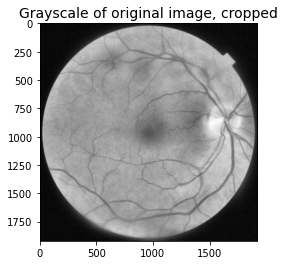

In [59]:
# Printing example grayscale healthy retina
print('Original size of cropped image:', images_jpg[1].shape)
print('Size of training dataset:', images_train.shape, 'i.e. it contains',images_train.shape[0],'images.')
plt.imshow(images_jpg[1], cmap='gray')
plt.title('Grayscale of original image, cropped', size=14)
plt.show()

It is common in eye fundus image registration to use either feature-based registration (FBR) or intensity-based registration (IBR). FBR methods use interest points, such as landmarks, along with local shape features of their neighborhoods to find point correspondences and estimate the spatial transformation between the images. However, FBR might not be a robust method for multi-modal registration. But since we are using a single image type for Tasks 1 & 2, we will start with a feature-based approach for registration.

One important feature of retinal images is the intersection of blood vessel segments, which has also proved to be a reliable biometric identification pattern.

## 1. Image Processing

First, it's necessary to perform good image processing to be able to extract relevant retinal features.

#### 1.1 Naka-Rushton filtering for compressing grayscale levels

This allows us to compress gray levels of the image and increase the contrast between the background and features.

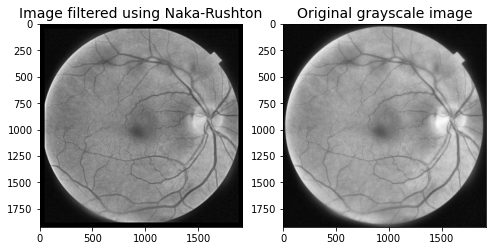

In [60]:
# Testing on example retinal image
img_gray = np.copy(images_jpg[0])
f, axarr = plt.subplots(1,2,figsize=(8,16))
axarr[0].imshow(filter_image(img_gray), cmap='gray')
axarr[1].imshow(images_jpg[0], cmap='gray')
axarr[0].set_title('Image filtered using Naka-Rushton', size=14)
axarr[1].set_title('Original grayscale image', size=14)
plt.show()

#### 1.2 Thresholding to separate vessels from background

Thresholding allows us to transform the image into black&white by using a binary threshold on all pixels after Naka-Rushton filtering.

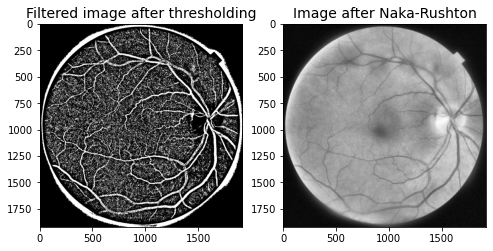

In [118]:
img_filtered = np.copy(images_jpg[0])
img_filtered = threshold(img_filtered)
f, axarr = plt.subplots(1,2,figsize=(8,16))
axarr[0].imshow(img_filtered, cmap='gray')
axarr[1].imshow(images_jpg[0], cmap='gray')
axarr[0].set_title('Filtered image after thresholding', size=14)
axarr[1].set_title('Image after Naka-Rushton', size=14)
plt.show()

#### 1.3 Denoising

This allows for a cleaner image with small noise/artifacts removed.

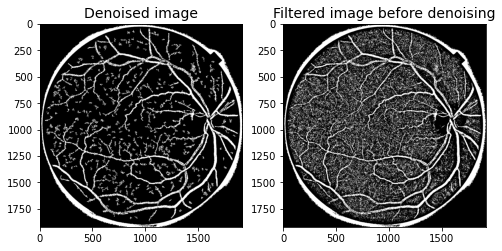

In [119]:
denoised = denoise_image(img_filtered)

fig, axarr = plt.subplots(1,2, figsize=(8,16))
axarr[0].imshow(denoised, cmap='gray')
axarr[0].set_title('Denoised image', fontsize=14)
axarr[1].imshow(img_filtered, cmap='gray')
axarr[1].set_title('Filtered image before denoising', fontsize=14)
plt.show()

#### 1.4 Filtering small dataset using Naka-Rushton, thresholding and denoising

In [64]:
images_filtered = []
for i in range(len(images_jpg)):
    images_filtered.append(denoise_image(threshold(filter_image(images_jpg[i]))))

## 2. Feature extraction and matching

Now our retinal images are filtered and denoised, with the vessels clearly to be seen. Using these preprocessed images, we will now seek to extract relevant features using traditional keypoint detection algorithms (SIFT, ORB, AKAZE) as well as a deep neural network through VoxelMorph.

### 2.1 Voxelmorph image registration

In [44]:
def train_voxelmorph(imgs):
    """
    Function used to train the VoxelMorph model using all images of a given centeredness in the dataset.
    The number of epochs and steps per epoch can be manually changed below.
    The output will be a trained vxm model.
    """
    print('Training VoxelMorph model')
    #Reducing image dimension
    edge_length = int(1920*0.3)
    dim1,dim2,dim3 = len(imgs),edge_length,edge_length
    images_train = np.zeros((dim1,dim2,dim3))
    
    for i in range(len(imgs)):
        imgs[i] = imgs[i]
        images_train[i] = resize(imgs[i], 0.3)

    #Configure model features
    ndim = 2
    unet_input_features = 2
    inshape = (*images_train[1].shape, unet_input_features)

    nb_features = [
        [32,32,32,32],       #encoder features
        [32,32,32,32,32,16]  #decoder features
    ]
    
    #Build model using square image with a multiple of 2^N where N is the number of features
    unet = vxm.networks.Unet(inshape=inshape, nb_features=nb_features)
    
    disp_tensor = tf.keras.layers.Conv2D(ndim, kernel_size=3, padding='same', name='disp')(unet.output)

    def_model = tf.keras.models.Model(unet.inputs, disp_tensor)

    spatial_transformer = vxm.layers.SpatialTransformer(name='transformer')
    moving_image = tf.expand_dims(unet.input[..., 0], axis=-1)
    moved_image_tensor = spatial_transformer([moving_image, disp_tensor])
    
    inshape = images_train.shape[1:]

    vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
    
    losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]
    lambda_param = 0.05
    loss_weights = [1, lambda_param]
    
    vxm_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights)
    
    #Train model
        
    train_generator = vxm_data_generator(images_train, batch_size=1)
    
    nb_epochs = 10
    steps_per_epoch = 100
    hist = vxm_model.fit_generator(train_generator, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=2)
    
    return vxm_model

In [9]:
def align_voxelmorph(imgs, vxm_model):
    """
    Registers misaligned image with fixed image using vxm model.
    Inputs: list of fixed image and misaligned image (length = 2) and train vxm model.
    Output: predicted alignment of misaligned image given the fixed image as base.
    """
    val_predict = vxm_model.predict(imgs)
    return val_predict[0][0, :, :, 0]

### 2.2 Accelerated-KAZE (AKAZE)

In [67]:
def align_akaze(fixed_img, misaligned_img, original_img):
    """
    Input: ndarray images. fixed_img is the 'fixed' image that the misaligned_img will register to using
    Accelerated-KAZE (AKAZE) keypoint detection algorithm. Original_img is the original image version
    of the misaligned image.
    Output: aligned image obtained by taking the misaligned_img and registered it on the fixed_img.
    """

    akaze = cv2.AKAZE_create()

    kp1, des1 = akaze.detectAndCompute(fixed_img, None)
    kp2, des2 = akaze.detectAndCompute(misaligned_img, None)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    good_matches = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good_matches.append([m])

    img = cv2.drawMatchesKnn(fixed_img, kp1, misaligned_img, kp2, good_matches, None,\
                             flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    cv2.imwrite('matches_AKAZE.jpg', img)

    ref_matched_kpts = np.float32([kp1[m[0].queryIdx].pt for m in good_matches])
    sensed_matched_kpts = np.float32([kp2[m[0].trainIdx].pt for m in good_matches])

    H, status = cv2.findHomography(sensed_matched_kpts, ref_matched_kpts, cv2.RANSAC, 5.0)

    aligned_image = cv2.warpPerspective(original_img, H, (original_img.shape[1], original_img.shape[0]))

    cv2.imwrite('warped_AKAZE.jpg', aligned_image)
    
    return aligned_image

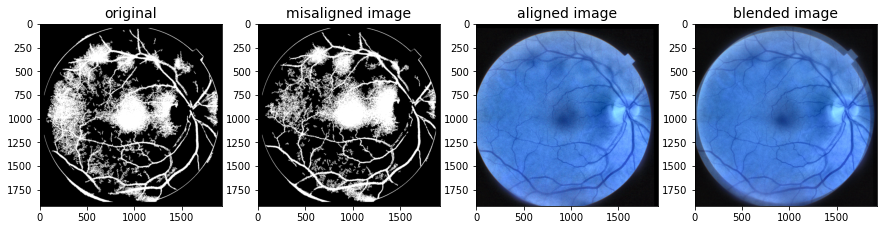

In [68]:
aligned_example = align_akaze(images_filtered[0], images_filtered[1], images_original[1])

fig, axarr = plt.subplots(1, 4, figsize=(15,45))

axarr[0].imshow(images_filtered[0], cmap='gray')
axarr[0].set_title('original', fontsize=14)
axarr[1].imshow(images_filtered[1], cmap='gray')
axarr[1].set_title('misaligned image', fontsize=14)
axarr[2].imshow(aligned_example, cmap='gray')
axarr[2].set_title('aligned image', fontsize=14)
axarr[3].imshow(blend(images_original[0], aligned_example), cmap='gray')
axarr[3].set_title('blended image', fontsize=14)
plt.show()

As we can see from the blended image, the vessels are superposed quite nicely.

### 2.3 Oriented FAST and rotated BRIEF (ORB)

In [11]:
def align_orb(fixed_img, misaligned_img, original_img):
    """
    Input: ndarray images. fixed_img is the 'fixed' image that the misaligned_img will register to using
    Accelerated-KAZE (AKAZE) keypoint detection algorithm.
    Output: aligned image obtained by taking the misaligned_img and registered it on the fixed_img.
    """

    orb = cv2.ORB_create()

    kp1 = orb.detect(fixed_img, None)
    kp2 = orb.detect(misaligned_img, None)

    kp1, des1 = orb.compute(fixed_img, kp1)
    kp2, des2 = orb.compute(misaligned_img, kp2)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    good_matches = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good_matches.append([m])

    img = cv2.drawMatchesKnn(fixed_img, kp1, misaligned_img, kp2, good_matches, None,\
                             flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    cv2.imwrite('matches_ORB.jpg', img)

    ref_matched_kpts = np.float32([kp1[m[0].queryIdx].pt for m in good_matches])
    sensed_matched_kpts = np.float32([kp2[m[0].trainIdx].pt for m in good_matches])

    H, status = cv2.findHomography(sensed_matched_kpts, ref_matched_kpts, cv2.RANSAC, 5.0)

    warped_image = cv2.warpPerspective(original_img, H, (original_img.shape[1], original_img.shape[0]))

    cv2.imwrite('warped_ORB.jpg', warped_image)

    return warped_image

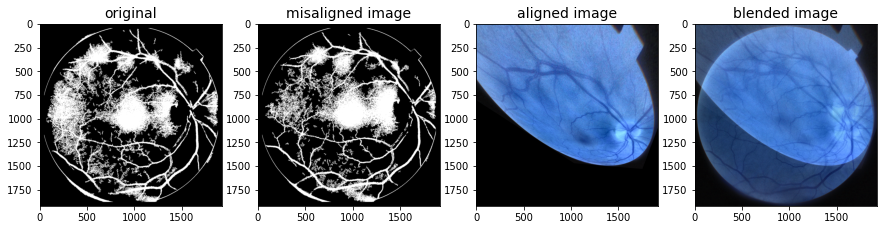

In [71]:
aligned_example = align_orb(images_filtered[0], images_filtered[1], images_original[1])

fig, axarr = plt.subplots(1, 4, figsize=(15,45))

axarr[0].imshow(images_filtered[0], cmap='gray')
axarr[0].set_title('original', fontsize=14)
axarr[1].imshow(images_filtered[1], cmap='gray')
axarr[1].set_title('misaligned image', fontsize=14)
axarr[2].imshow(aligned_example, cmap='gray')
axarr[2].set_title('aligned image', fontsize=14)
axarr[3].imshow(blend(images_original[0], aligned_example), cmap='gray')
axarr[3].set_title('blended image', fontsize=14)
plt.show()

ORB is more efficient and fast but suffers from performance issues and needs further optimization.

### 2.4 SIFT

In [12]:
def align_sift(fixed_img, misaligned_img, original_img):
    """
    Input: ndarray images. fixed_img is the 'fixed' image that the misaligned_img will register to using
    Accelerated-KAZE (AKAZE) keypoint detection algorithm.
    Output: aligned image obtained by taking the misaligned_img and registered it on the fixed_img.
    """

    sift = cv2.SIFT_create()

    kp1, des1 = sift.detectAndCompute(fixed_img, None)
    kp2, des2 = sift.detectAndCompute(misaligned_img, None)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    good_matches = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good_matches.append([m])

    img = cv2.drawMatchesKnn(fixed_img, kp1, misaligned_img, kp2, good_matches, None,\
                             flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    cv2.imwrite('matches_SIFT.jpg', img)

    ref_matched_kpts = np.float32([kp1[m[0].queryIdx].pt for m in good_matches])
    sensed_matched_kpts = np.float32([kp2[m[0].trainIdx].pt for m in good_matches])

    H, status = cv2.findHomography(sensed_matched_kpts, ref_matched_kpts, cv2.RANSAC, 5.0)

    warped_image = cv2.warpPerspective(original_img, H, (original_img.shape[1],original_img.shape[0]))

    cv2.imwrite('warped_SIFT.jpg', warped_image)
    
    return warped_image

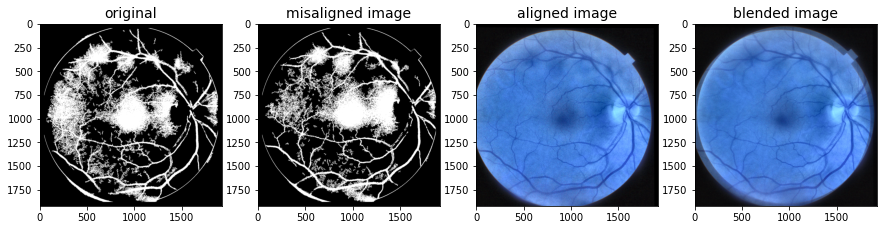

In [72]:
aligned_example = align_sift(images_filtered[0], images_filtered[1], images_original[1])

fig, axarr = plt.subplots(1, 4, figsize=(15,45))

axarr[0].imshow(images_filtered[0], cmap='gray')
axarr[0].set_title('original', fontsize=14)
axarr[1].imshow(images_filtered[1], cmap='gray')
axarr[1].set_title('misaligned image', fontsize=14)
axarr[2].imshow(aligned_example, cmap='gray')
axarr[2].set_title('aligned image', fontsize=14)
axarr[3].imshow(blend(images_original[0], aligned_example), cmap='gray')
axarr[3].set_title('blended image', fontsize=14)
plt.show()

SIFT performs similar to AKAZE in terms of performance and runtime.